In [3]:
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt

#On construit A
A = 2 * np.diag(np.ones(6)) - np.diag(np.ones(5),-1) - np.diag(np.ones(5),1)
print(A)

[[ 2. -1.  0.  0.  0.  0.]
 [-1.  2. -1.  0.  0.  0.]
 [ 0. -1.  2. -1.  0.  0.]
 [ 0.  0. -1.  2. -1.  0.]
 [ 0.  0.  0. -1.  2. -1.]
 [ 0.  0.  0.  0. -1.  2.]]


In [4]:
def mineurs(A):
    """
    Renvoie les determinants mineurs d'une matrice A.
    On se sert d'une définition par récurrence démontrée plus haut pour les determiner 
    un a un.
    On note dk = |A_k| ou A_k est la matrice A ou l'on a supprime les n-k dernieres 
    lignes et colonnes
    """
    n = len(A[0])
    # on va operer des modifications sur la matrice (suppressions de lignes/colonnes)
    # on prefere donc operer sur une copie
    B = A.copy()
    #par convention, le determinant mineur dans le cas k = 0 vaut 1
    d0 = 1
    
    # On cherche a determiner d1, une premiere approche est
    # de supprimer les n-1 dernieres lignes et colonnes
    # puis de calculer le determinant avec numpy
    #for k in range(n-1, 0, -1):
    #    B = np.delete(B, k, 0)
    #    B = np.delete(B, k, 1)
    #d1 = np.linalg.det(B)
    
    #mais on peut remarquer que d1 corespond au determinant de la matrice A où 
    # l'on a supprimé les n-1 dernieres lignes et colonnes
    # autrement dit c'est le scalaire A[0][0]
    d1 = B[0][0]
    #liste stockant tous les determinants mineurs
    deltas = [d0, d1]
    
    for k in range(2, n+1):
        # on applique ensuite la formule de recurrence pour deduire chacun des determinants
        d = A[k-1][k-1]*deltas[k-1] - A[k-1][k-2]*A[k-1][k-2]*deltas[k-2]
        # on les ajoute ensuite dans la liste
        deltas.append(d)

    return deltas

In [5]:
def alphas(A):
    """
        Implementation de la formule donnée pour calculer les alphas
    """
    deltas = mineurs(A)
    n = len(A[0])
    
    alphs = []
    for k in range(1, n+1):
        # On applique la formule de \alpha_k
        alphs.append(deltas[k]/deltas[k-1]) 
        
    return alphs

In [6]:
def decLU_tridiag(A):
    """
    On sait que la decomposition LU d'une matrice tridiagonale prend
    une forme particulière
    on choisit donc de coder une implementation specifique 
    de la decomposition LU 
    dans le contexte de l'exercie où la matrice est tridiagonale.
    On se sert de coefficients (\alpha)_i calculé
    """
    n = A.shape[0]
    
    #la matrie L (triang. inf) a des 1 sur sa diagonale principale
    #on l'initialise donc comme etant la matrice identitee
    L = np.eye(n)
    
    alphs = alphas(A)
    #on connait la forme que doit prendre L
    for i in range(0, n-1): #on va seulement jusqu'a n-1 car on modifie seulement sur diagonale inférieure
        L[i+1][i] = A[i+1][i]/alphs[i]
    
    #on connait la forme que doit prendre U
    U = np.zeros((n,n))
    for i in range(0, n):
        U[i][i] = alphs[i] #sur la diagonale de U, on a les coefficients alpha
        if i < n-1: #sur la diagonale superieure de U, on a la diagonale supérieure de A
            U[i][i+1] = A[i][i+1] 
             
    return L, U

In [7]:
"""
Methodes pour construire une matrice 
issue de l'extraction de la partie inferieure/superieure à la 
diagonale de A
"""

def triangle_inf(A):
    n = A.shape[0]
    res = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            if j < i:
                res[i][j] = A[i][j]
    return res

def triangle_sup(A):
    n = A.shape[0]
    res = np.zeros((n,n))
    for i in range(0, n):
        for j in range(0, n):
            if i < j:
                res[i][j] = A[i][j]
    return res

In [8]:
def mjacobi(A, B, XINIT, tol, nmaxit):
    
    xk = XINIT
    # On construit une matrice S inversible, facilement inversible. 
    # Pour cela, on considère la matrice diagonale en l'extrayant de A.
    # Une matrice diagonale D = (di)_i non nulle est inversible 
    # et son inverse est (1/di)_i
    D = np.diag(np.diag(A))
    Di = np.linalg.inv(D)
    
    
    # On construit une matrice T tel que A = D - L - U avec L/U triangulaire inferieure/superieure
    L = -triangle_inf(A)
    U = -triangle_sup(A)
    
    # On sait qu'une condition necessaire et suffisante a la convergence 
    # des methodes iteratives 
    # x_{k+1} = Mx_k + b est que le rayon spectral de M soit <= 1
    # le rayon spectral en dimension finie est definie comme le maximum des valeurs propres
    # Dans notre cas, M = D^{-1}(L+U)
    if np.linalg.norm(np.linalg.eigvals(Di@(L+U)), np.inf) > 1:
        return 0, np.zeros(XINIT.shape[0]), nmaxit
    
    # variable comptant le nombre d'iterations
    # pour s'assurer que l'algorithme termine rapidement meme si la méthode de Jacobi ne converge pas assez rapidement
    # vers la solution
    iterations = 0
    
    #tant que ||Ax_k - B|| > tol c'est qu'on est encore éloigné d'une approximation satisfaisante de la solution
    #tant que le nombre d'iterations est inferieure a la borne d'iterations max, on peut continuer d'iterer
    while (np.linalg.norm(np.dot(A,xk) - B) > tol) and (iterations < nmaxit):
        #on incremente le nombre d'iteration faits
        iterations += 1
        
        #on se sert de la relation de recurrence dans le cas de la methode de Jacobi
        xk = Di@np.dot(L+U, xk) + np.dot(Di, B)
        
        #Si ||Ax_k - B|| <= tol, nous sommes satisfait de notre approximation, nous mettons info = 1. 
        #C'est notre dernier tour de boucle
        #if np.linalg.norm(np.dot(A,xk) - B) <= tol:
        #    print("ici")
        #    info = 1
    return 1, xk, iterations

In [9]:
# On cherche a resoudre AX = B avec la methode de Jacobi pour B le vecteur dont chaque composante vaut 1
# et XINIT = (0, \dots, 0)
# et pour une tolerance de 0.001 et au maximum 100 iterations
B = np.ones(6)
print(mjacobi(A, B, np.zeros(6), 0.001, 100))

(1, array([ 2.99890014,  4.99801811,  5.99752863,  5.99752863,  4.99801811,
        2.99890014]), 75)


In [10]:
def mrelax(A, B, XINIT, w, tol, nmaxit):
    xk = XINIT
    iterations = 0
    
    # On construit une matrice S inversible, facilement inversible. 
    # Pour cela, on considère la matrice diagonale en l'extrayant de A.
    # Une matrice diagonale D = (di) non nulle est inversible et son 
    # inverse est (1/di)
    D = np.diag(np.diag(A))
    
    
    # On construit une matrice T tel que A = D + L - U 
    # avec L/U triangulaire inferieure/superieure
    L = -triangle_inf(A)
    U = -triangle_sup(A)
    
    M = 1/w*D - L
    Mi = np.linalg.inv(M)
    N = (1-w)/w*D + U
    
    while (np.linalg.norm(np.dot(A,xk) - B) > tol) and (iterations < nmaxit):
        iterations += 1
        xk = np.dot(Mi@N, xk) + np.dot(Mi, B)
    
    return 1, xk, iterations

In [11]:
B = 2*np.ones(6)
tol = 0.0001
xinit = np.zeros(6)
w = 1

infjac, xjac, itjac = mjacobi(A, B, xinit, tol, 100)
infrel, xrel, itrel = mrelax(A, B, xinit, w, tol, 100)

if infjac == 1:
    print("La methode de Jacobi converge pour la matrice A")
    print("On trouve : x = {} en {} iterations. L'erreur finale est de {}".format(xjac, itjac, np.linalg.norm(np.linalg.norm(np.dot(A, xjac) - B))))
else:
    print("La methode de Jacobi ne converge pas pour la matrice A")
    
if infrel == 1:
    print("La methode de relaxation converge pour la matrice A")
    print("On trouve : x = {} en {} iterations pour w = {}. L'erreur finale est de {}".format(xrel, itrel, w,np.linalg.norm(np.linalg.norm(np.dot(A, xrel) - B))))
else:
    print("La methode de relaxation ne converge pas pour la matrice A")
    
D = np.diag(np.diag(A))
Di = np.linalg.inv(D)

L = -triangle_inf(A)
U = -triangle_sup(A)
M = Di@(L+U)
print(np.linalg.norm(np.linalg.eigvals(M), np.inf))

La methode de Jacobi converge pour la matrice A
On trouve : x = [  5.99983778   9.99970768  11.99963549  11.99963549   9.99970768
   5.99983778] en 100 iterations. L'erreur finale est de 0.00013854028144629868
La methode de relaxation converge pour la matrice A
On trouve : x = [  5.99988013   9.99980539  11.99978135  11.99980301   9.99985767
   5.99992883] en 53 iterations pour w = 1. L'erreur finale est de 8.976361155897779e-05
0.900968867902


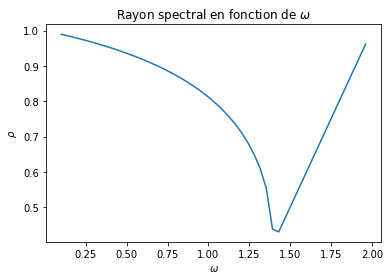

In [12]:
# on cree un tableau de valeur de w entre 0.1 et 2 (2 exclus)
# afin d'échantillonner et laisser matplotlib tracer les courbes
ws = np.linspace(0.1, 2, endpoint=False)

#Comme précédement, on reconstruit les matrices intermédiaires aux calculs
D = np.diag(np.diag(A))
L = -triangle_inf(A)
U = -triangle_sup(A)


rhos = [] #liste stockant tous les rayons spectrals construit
# Pour chaque w possible, on applique les memes calculs que precedemment
for w in ws:
    # Cette fois, M depend de w, donc on la nomme Mw
    Mw = 1/w*D - L
    Miw = np.linalg.inv(Mw)
    Nw = (1-w)/w*D + U
    # on rajoute le rayon spectral de Mw a la liste
    # 
    rhos.append(np.linalg.norm(np.linalg.eigvals(Miw@Nw), np.inf))
plt.title(r"Rayon spectral en fonction de $\omega$")
plt.xlabel(r"$\omega$")
plt.ylabel(r"$\rho$")
plt.plot(ws, rhos)
plt.show()

On observe que pour $\omega$ proche de $\omega_0 = 1.40$, le rayon spectrale est minimisé.

On conjecture que c'est la valeur optimale pour une convergence rapide de la méthode de relaxation

In [13]:
w0 = 1.40
_, xrel0, itrel0 = mrelax(A, B, xinit, w0, tol, 1000)
print("On trouve x = {} en {} iterations pour w = {}. L'erreur finale est de {}".format(xrel0, itrel0, w0,np.linalg.norm(np.linalg.norm(np.dot(A, xrel) - B))))

_, xrel, itrel = mrelax(A, B, xinit, w, tol, 1000)

print("On trouve x = {} en {} iterations pour w = {}. L'erreur finale est de {}".format(xrel, itrel, w,np.linalg.norm(np.linalg.norm(np.dot(A, xrel) - B))))

On trouve x = [  5.99995515   9.99995237  11.99996952  11.99998122   9.99999113
   5.99999718] en 16 iterations pour w = 1.4. L'erreur finale est de 8.976361155897779e-05
On trouve x = [  5.9999062    9.99983129  11.99978203  11.99976583   9.99979076
   5.99986564] en 280 iterations pour w = 1.962. L'erreur finale est de 9.916087740468423e-05
